# Image classification

In this notebook you will learn how to use two well known image classification techniques, the bag of words algorithm as well as the convolutional neural networks.

Requirements:
- Python 3
- opencv-python (4.6.0)
- scikit-learn (1.2.0)


## The problem

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60000 examples and a test set of 10000 examples. Both datasets are saved in a csv file where each line contains a label and the intensity values of a 28x28 grayscale image that depicts a piece of clothing. This dataset contains only objects of 10 classes.

The following function reads the contents of one of this csv files:

In [103]:
import numpy as np
import csv
import cv2 as cv
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [104]:
# Load a csv file of the fashion MNIST dataset
# - filename: path filename of the csv file
# Returns the list of images and the list of corresponding labels

def load_mnist_dataset(filename):
    f = open(filename, 'r')
    reader = csv.reader(f, delimiter=',')
    data = []
    images = []
    labels = []
    next(reader)
    for row in reader:
        labels.append(int(row[0]))
        images.append(np.array(row[1:]).astype(np.uint8).reshape(28,28))
    f.close()
    return images, labels


We can use the previous function to read and display some images of both datasets (it can take a while):

In [105]:
train_images, train_labels = load_mnist_dataset("res/fashion-mnist_train.csv")
test_images, test_labels =  load_mnist_dataset("res/fashion-mnist_test.csv")

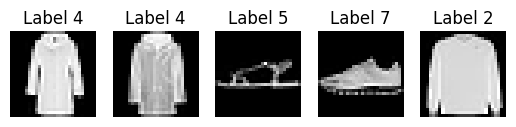

In [106]:
n_samples = 5

f, ax = plt.subplots(1,n_samples)
for i in range(n_samples):
    idx = np.random.randint(0, high=len(train_images))
    ax[i].imshow(train_images[idx], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Label {train_labels[idx]}')
plt.show()

In this notebook you will develop a methodology to classify an input image into its corresponding label.

## Bag of words
The first approach will use the Bag of Words algorithm. This algorithm consists of the following steps:

1. Given a set of descriptors computed from the training images, define a vocabulary of visual words.
2. For each image in the training dataset
    1. Compute its descriptors
    2. Assign each descriptor to the closest word in the vocabulary
    3. Build a histogram of words
3. Use the histograms and the labels of each image in the training dataset to train a classifier 
4. Save both the vocabulary and trained classifier

For inference, follow the next steps:
1. Compute the descriptors of the input image
2. Assign each descriptor to the closest word in the saved vocabulary
3. Build the histogram
4. Use the trained classifier to obtain the label of the input image

### Step 1: Define a vocabulary of visual words


In order to build the vocabulary, the first step is to describe the input image using keypoints and its descriptors. To this end, you should use an efficient and robust algorithm, for example, SIFT. 



In [107]:
detector = cv.SIFT_create()

The second step is computing descriptors of images in training dataset and cluster all the gathered descriptors using a clustering algorithm, e.g. KMeans. The number of cluser centers defines the size of the vocabulary. The class `cv.BOWKMeansTrainer` helps with these tasks:

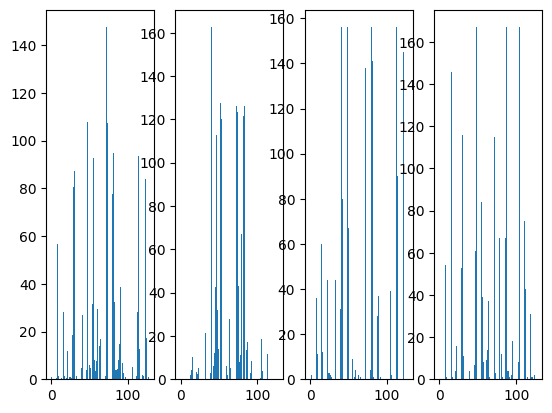

In [108]:
voc_size = 4 # Size of the vocabulary (toy example)

bow_trainer = cv.BOWKMeansTrainer(voc_size)

# Compute the descriptors of a image and add them to the bow trainer
image = train_images[0]
keypoints, descriptors = detector.detectAndCompute(image, np.ones(image.shape, dtype=np.uint8))
if descriptors is not None:
    bow_trainer.add(descriptors)

# Cluster the descriptors, this is, get the vocabulary
vocabulary = bow_trainer.cluster() 
f, ax = plt.subplots(1, voc_size)
for idx, word in enumerate(vocabulary):
    ax[idx].bar(range(0, word.shape[0]), word)
plt.show()

#### Exercise
Implement the following function that computes the vocabulary from the images in the training set.

**Note**: the number of descriptors in the training dataset (60000 images) is near 250k. In order to speed up the computation of the vocabulary, select only a random set of images of each class (10-20%).


In [109]:
def get_vocabulary(voc_size, images, labels, detector, output_filename):
    bow_trainer = cv.BOWKMeansTrainer(voc_size)
    
    ## To do: add descriptors to the bow_trainer from the input images

  
    # Perform train/test split and use only the training data for vocabulary creation
    _, train_indices = train_test_split(np.arange(len(train_images)), test_size=0.15, random_state=42)
    
    for idx in train_indices:
        image = train_images[idx]
        keypoints, descriptors = detector.detectAndCompute(image, np.ones(image.shape, dtype=np.uint8))
        if descriptors is not None:
            bow_trainer.add(descriptors)
    
    # Cluster the descriptors to get the vocabulary
    vocabulary = bow_trainer.cluster()
    np.save(output_filename, vocabulary)
    

    # Cluster the descriptors, this is, get the vocabulary
    f, ax = plt.subplots(1, voc_size)
    for idx, word in enumerate(vocabulary):
        ax[idx].bar(range(0, word.shape[0]), word)
    plt.show()

    return vocabulary    

#### Exercise
Compute and save vocabularies of three suitable sizes


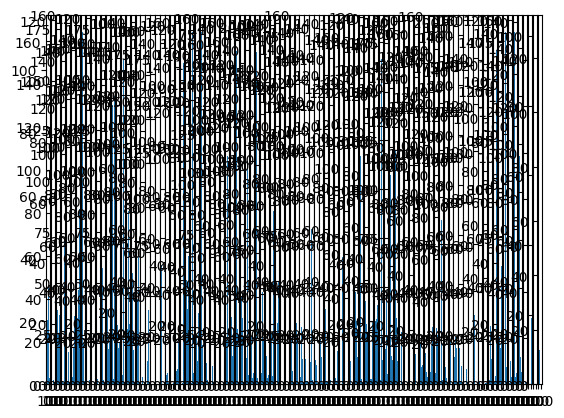

In [110]:
# vocabulary size 1 

voc_size_1 = 100
vocabulary_1 = get_vocabulary(voc_size_1, train_images, train_labels, detector, "vocabulary_1.npy")

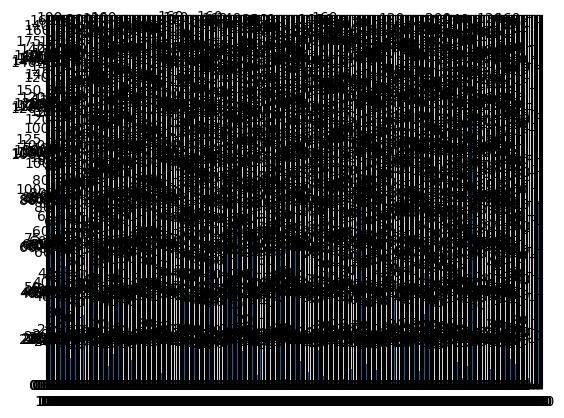

In [111]:
# vocabulary size 2

voc_size_2 = 300
vocabulary_2 = get_vocabulary(voc_size_2, train_images, train_labels, detector, "vocabulary_2.npy")

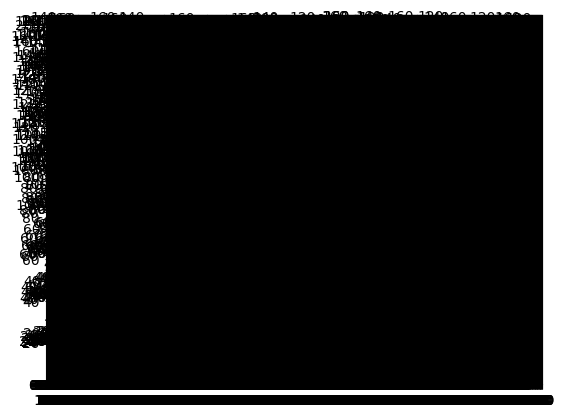

In [112]:
# vocabulary size 3

voc_size_3 = 600
vocabulary_3 = get_vocabulary(voc_size_3, train_images, train_labels, detector, "vocabulary_3.npy")

### Step 2: Build histograms from the training dataset

The class `cv.BOWImgDescriptorExtractor` simplifies this operation. The constructor of this class needs two parameters: a keypoint detector and descriptor as well as an algorithm to match the descriptors to the cluster centers of the vocabulary. In our case, we use a brute force matcher and the SIFT detector that we have defined previously.

In [113]:
matcher = cv.BFMatcher(cv.NORM_L2)
bow_extractor = cv.BOWImgDescriptorExtractor(detector, matcher)

We have to init this class with a previously defined vocabulary.

In [114]:
bow_extractor.setVocabulary(vocabulary) # toy example

After that, we can compute the histogram of a given image as follows:

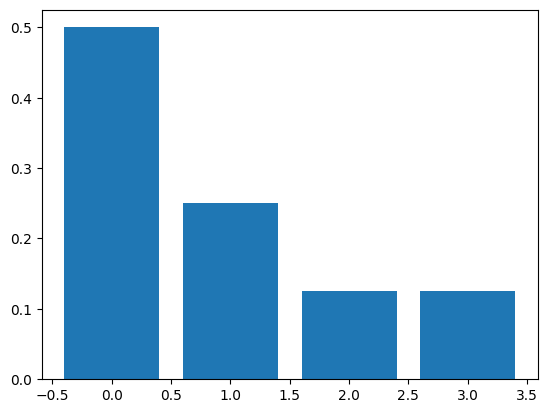

In [115]:
keypoints = detector.detect(train_images[0])
histograms = bow_extractor.compute(train_images[0], keypoints)
plt.bar(range(histograms[0].shape[0]), histograms[0])
plt.show()

Be careful, the output histogram is `None` when all its values are 0.

#### Exercise
Implement a function that computes the histograms of a set of images. If the `bow_extractor` returns `None` when computing the histogram, replace this value by an array of 0s.  

In [116]:
def get_histograms(bow_extractor, images, vocabulary_size):
    histograms = []


    for image in images:
        keypoints = detector.detect(image)
        histogram = bow_extractor.compute(image, keypoints)
        if histogram is not None:
            
            histograms.append(histogram[0])
        else:
            histograms.append(np.zeros(vocabulary_size))
        
    histograms =  np.array(histograms)      

    return histograms
    

### Step 3: Train a classifier
Use the histograms and the labels to train a classifier [(SVM, Random Forest, KNN, ...)](https://scikit-learn.org/stable/supervised_learning.html). Compute the success rate after training in the training set by comparing the classifier outputs with the actual labels as well as the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html).

Repeat the procedure with the other two vocabularies that you have built.

**Important**: do not forget to set the appropriate vocabulary to the `bow_extractor`before computing the histograms

**Note**: if you use SVM, apply a grid search in order to find the best parameters.




In [120]:
#KNN

def knn_hyperparameter_tuning(bow_extractor, train_images, train_labels, voc_size, cv=2):
    # Get histograms
    histograms = get_histograms(bow_extractor, train_images, voc_size)
    
    # Define the parameter grid for hyperparameter tuning
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}  # Define the range of k values to try

    # Initialize KNN classifier
    knn_classifier = KNeighborsClassifier()

    # Perform grid search cross-validation
    grid_search = GridSearchCV(knn_classifier, param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(histograms, train_labels)

    # Get the best hyperparameters
    best_k = grid_search.best_params_['n_neighbors']
    print("Best value of k:", best_k)

    # Train the classifier with the best value of k
    best_knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
    best_knn_classifier.fit(histograms, train_labels)

    # Predict labels for the training set using the best classifier
    predicted_labels = best_knn_classifier.predict(histograms)

    # Compute the success rate
    accuracy = accuracy_score(train_labels, predicted_labels)
    print("Accuracy:", accuracy)
    
    conf_matrix = confusion_matrix(train_labels, predicted_labels)
    ConfusionMatrixDisplay(conf_matrix).plot()

    return best_knn_classifier, best_k

Best value of k: 13
Accuracy: 0.5986166666666667


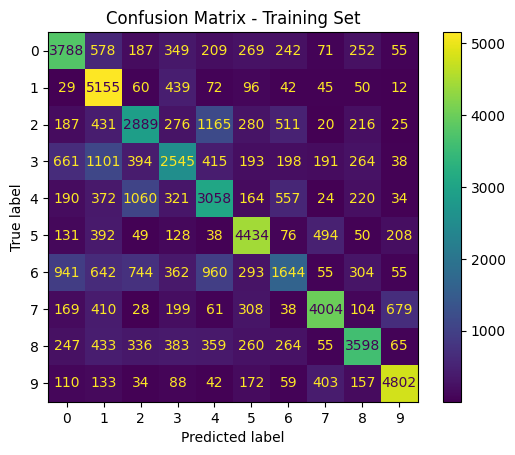

In [121]:
# vocabulary size 1

bow_extractor.setVocabulary(vocabulary_1)
best_knn_classifier, best_k = knn_hyperparameter_tuning(bow_extractor, train_images, train_labels, voc_size_1)

plt.title('Confusion Matrix - Training Set')
plt.show()

Best value of k: 5
Accuracy: 0.6709166666666667


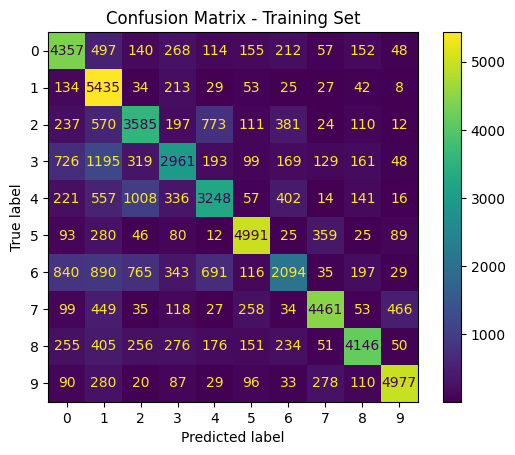

In [122]:
# vocabulary size 2

bow_extractor.setVocabulary(vocabulary_2)
best_knn_classifier, best_k = knn_hyperparameter_tuning(bow_extractor, train_images, train_labels, voc_size_2)

plt.title('Confusion Matrix - Training Set')
plt.show()

Best value of k: 5
Accuracy: 0.6778833333333333


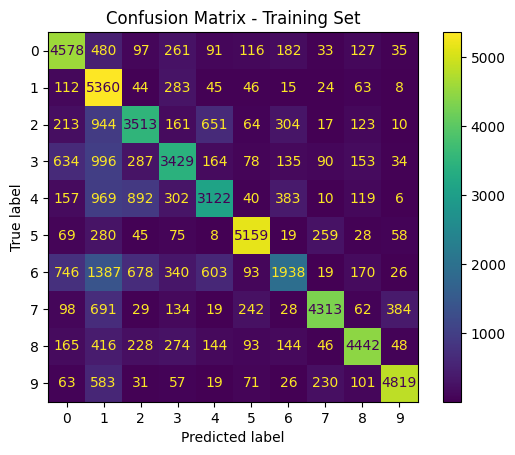

In [123]:
# vocabulary size 3

bow_extractor.setVocabulary(vocabulary_3)
best_knn_classifier, best_k = knn_hyperparameter_tuning(bow_extractor, train_images, train_labels, voc_size_3)

plt.title('Confusion Matrix - Training Set')
plt.show()

### Step 4: Test the classifier

Test the classifier with the test dataset, compute the success rate and the confussion matrix.

Best value of k: 1
Accuracy: 0.9069


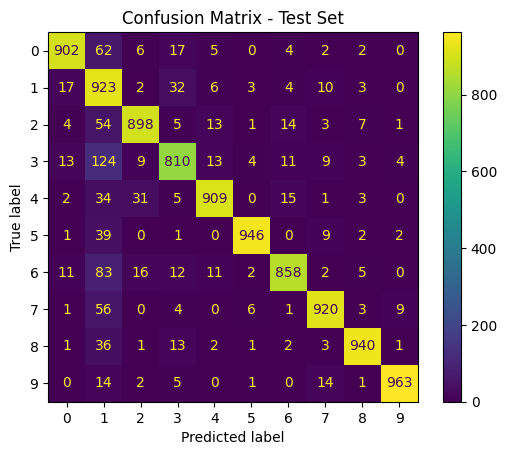

In [124]:
### Write your code here

bow_extractor.setVocabulary(vocabulary_3)
best_knn_classifier, best_k = knn_hyperparameter_tuning(bow_extractor, test_images, test_labels, voc_size_3)

plt.title('Confusion Matrix - Test Set')
plt.show()